---
# **データサイエンス基礎　第10回課題**
## **【決定木・ランダムフォレスト】気象データより天気概況を推定するモデルの作成**
---
### 1. データの概要
　今回扱うデータは，第7，8回と同様，[気象庁の過去の気象データ](https://www.data.jma.go.jp/gmd/risk/obsdl/index.php)より得られる埼玉県熊谷市の気象データと，[東京電力パワーグリッド株式会社が公表する過去の電力使用実績データ](https://www.tepco.co.jp/forecast/)より得られる東京エリアの電力使用実績データを，それぞれのSheetに記述し，1つのExcelファイルとしてまとめたものである．
> [https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx](https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx)  
  
　このExcel形式のデータを処理し，天気概況に関する決定木およびランダムフォレストモデルを作成する．
### 2. $YYYY$ 年 $MM$ 月の気象データより天気概況を推定する決定木モデルの作成
#### (1) データの読み込み
　まず，各シートの1行目に関して，今回タイトルとして扱いたい情報が含まれない．したがって，1行目を無視する必要がある．また，2，3行目もタイトル行として扱うには不備があり，扱いにくい．以上より，1，2，3行目を無視し，データフレームのタイトル行は自分で定義する必要があると考えられる．  
　また，気象データのうち，独立変数として用いられる可能性があるのは，”平均気温”，”最高気温”，”最低気温”，”降水量”，”日照時間”，”降雪量”，”平均風速”，”平均蒸気圧”，”平均湿度”，”平均現地気圧”の10個である．  
　さらに，電力需要のデータは，1日の1時間毎にデータが記録されている．したがって，この平均値をとり，その日の電力需要とする必要がある．  
　重回帰モデルの作成・出力には，Pythonライブラリであるstatsmodelsを利用する．

In [79]:
# ライブラリの読み込み
# %pip install --upgrade pip
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install openpyxl
# %pip install sympy
# %pip install scipy
# %pip install re
# %pip install jaconv
# %pip install scikit-learn
# %pip install statsmodels
# %pip install seaborn
# %pip install pmdarima
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import sympy as sp
import scipy.stats as stats
import re
import jaconv 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import itertools
import matplotlib.dates as mdates
import pmdarima as pm
from IPython.display import clear_output
from sklearn.metrics import r2_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier


# 変数の定義
year = 2020                # 対象年度      ：指定しない場合はFalse
month = 1                  # 対象月        ：指定しない場合はFalse

# 対象気象データ名（独立変数候補名）
X_name = ['平均気温', '最高気温', '最低気温', '降水量', '日照時間', '降雪量', '平均風速', '平均蒸気圧', '平均湿度', '平均現地気圧']   

# 対象気象データ（従属変数名） 
target = '天気概況' 


# 気象データのExcel Sheetの読み込み
df_weather = pd.read_excel( 'ds07_temp_power_exercise.xlsx', 
                        sheet_name='2020熊谷市気象データ_data', skiprows=[0,1,2],
                        names= ['年月日', '平均気温', '', '', '最高気温', '', '', '', '', '最低気温', '', '', '', '', 
                                '降水量', '', '', '', '日照時間', '', '', '', '降雪量', '', '', '', '平均風速', '', '', 
                                '平均蒸気圧', '', '', '平均湿度', '', '', '平均現地気圧', '', '', '', '', '', '天気概況', '', ''])
df_weather['年月日'] = pd.to_datetime(df_weather['年月日'], format='%Y/%m/%d')

#### (2) 学習用データと検証用データの分割
　機械学習などの慣習では，基のデータから4：1の割合で学習用と検証用にデータを分割する方法があるが，今回は予測する対象の年月が決まっているため，それを検証用データとし，それ以外を学習用データとした．

In [80]:
# 対象データの振り分け（X：独立変数，Y：従属変数）
X_train = df_weather[(df_weather['年月日'].dt.year != year) | (df_weather['年月日'].dt.month != month)][X_name]
X_test =  df_weather[(df_weather['年月日'].dt.year == year) & (df_weather['年月日'].dt.month == month)][X_name]
Y_train = df_weather[(df_weather['年月日'].dt.year != year) | (df_weather['年月日'].dt.month != month)][target]
Y_test = df_weather[(df_weather['年月日'].dt.year == year) & (df_weather['年月日'].dt.month == month)][target]

#### (3) 決定木の深さと精度（F値）の関係を探索

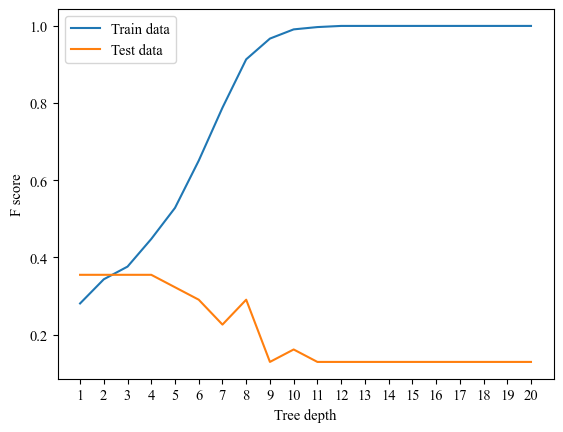

Best depth: 1, Best test F score: 0.3548387096774194


In [81]:
# 決定木の深さに対する最良モデルのF値を計算
depths = range(1,21)
F_score_train = []
F_score_test = []
for depth in depths:
    model = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    model = model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    F_score_train.append(f1_score(Y_train, Y_train_pred, average="micro"))
    F_score_test.append(f1_score(Y_test, Y_test_pred, average="micro"))

# 結果をCSVに保存
results_df = pd.DataFrame({'Depth': depths, 'Train F_score': F_score_train, 'Test F_score': F_score_test})
results_df.to_csv('decision_tree_F_score.csv', index=False)

# グラフの描画
plt.figure()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10.5
plt.plot(depths, F_score_train, label='Train data')
plt.plot(depths, F_score_test, label='Test data')
plt.xticks(depths)
plt.xlabel('Tree depth')
plt.ylabel('F score')
plt.legend()
plt.show()

# 最終結果の出力
best_depth = depths[F_score_test.index(max(F_score_test))]
best_F_score = max(F_score_test)
print(f'Best depth: {best_depth}, Best test F score: {best_F_score}')


　グラフより，木の深さが大きくなるほど，学習用のデータに対する精度が向上していることが分かる．これは，許容される決定木の分岐回数が多くなるため，学習用のデータをより厳密に仕分けできるようになったためであると考えられる．一方で，検証用データに対する精度は減少しており，木の深さが増加するにつれて過学習となっていることが確認できる．  
　今回の気象データでは，木の深さが 1 の場合が最も精度の良いモデルとなったが，木の深さが 8 の時点で精度が急激に向上しており，このモデルも改良次第では，最適となる可能性がある．  
　また，学習用データと検証用データを2022年1月のデータ（31個）から4：1で分割をした場合は，検証用のデータの精度が一定となってしまい，上手く考察することができなかった．これは，検証用のデータが少なすぎて，推定精度に変化が起こらなかった（推定しやすい部分はどの深さでも推定可能で，推定しにくいものはどの深さであろうが推定できなかった）ものと考えられる．
#### (4) 最良決定木モデルの可視化と説明変数の重要度（寄与度）

Max depth: 1
F score: 0.3548387096774194


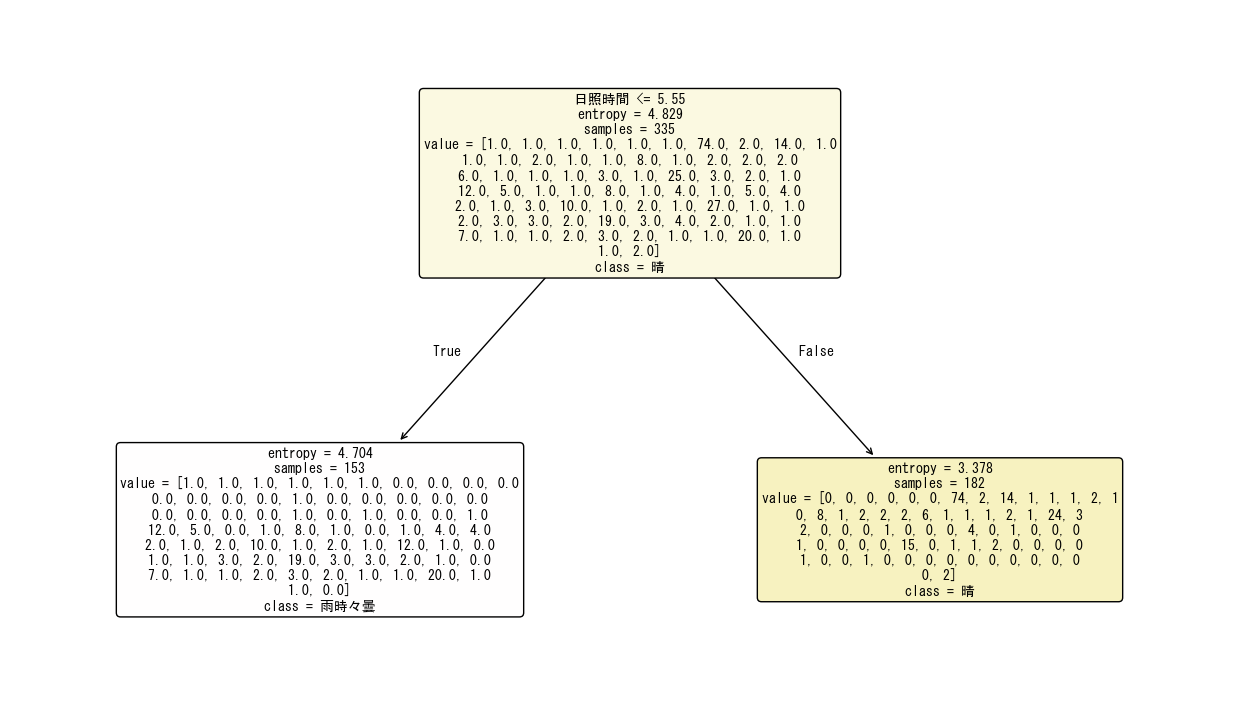

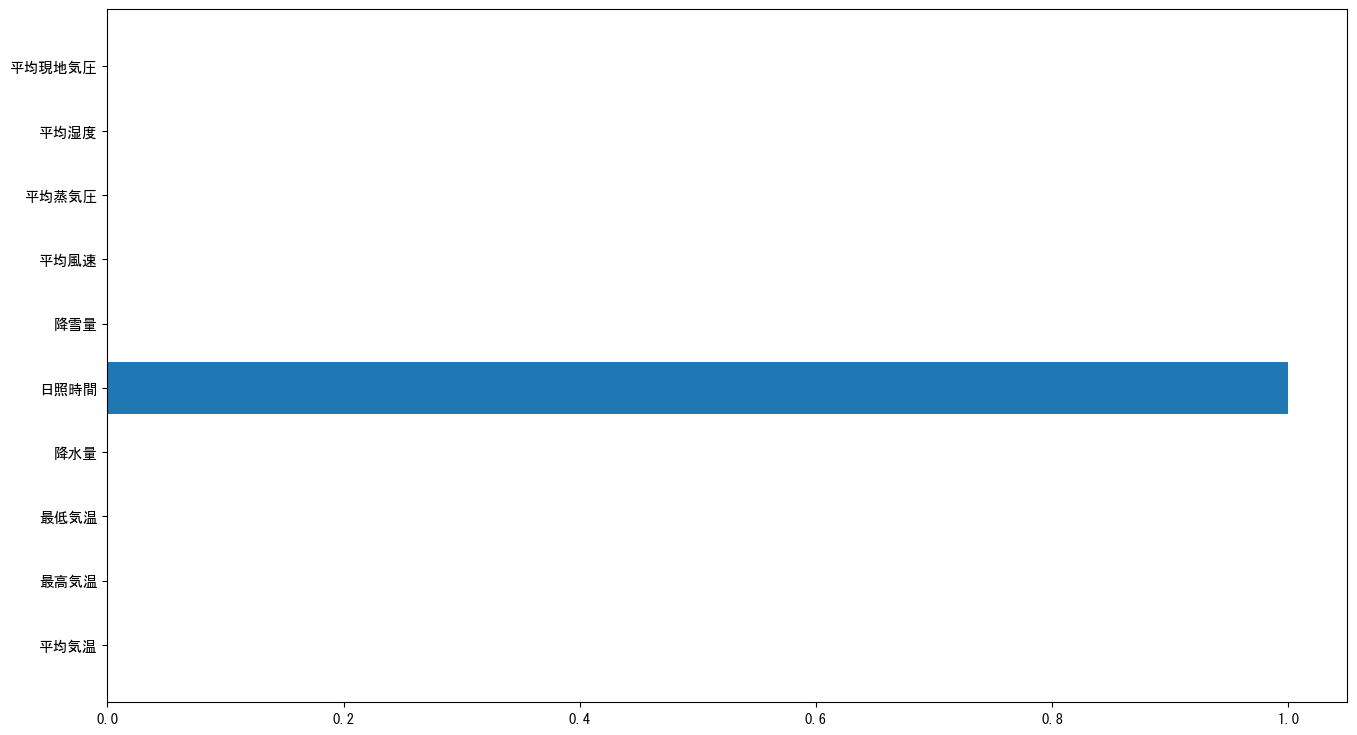

In [82]:
# 決定木モデルを可視化
_depth = best_depth
clf = DecisionTreeClassifier(criterion='entropy', max_depth=_depth)
clf = clf.fit(X_train, Y_train)
print('Max depth:', _depth)
print('F score:', f1_score(Y_test, clf.predict(X_test), average="micro"))
plt.figure(figsize=(16, 9))
plt.rcParams['font.family'] = 'MS Gothic'
plot_tree(clf, filled=True, feature_names=X_name, class_names=list(clf.classes_), rounded=True, fontsize=10)
plt.show()

# 各説明変数の重要度（寄与率）を計算して描画
importances = clf.feature_importances_
plt.figure(figsize=(16, 9))
plt.rcParams['font.size'] = 10.5
plt.rcParams['font.family'] = 'MS Gothic'
plt.barh(range(len(X_name)), clf.feature_importances_)
plt.yticks(ticks=np.arange(len(X_name)), labels=X_name)
plt.show()

　今回の最良モデルにおける決定木の深さが 1 となった理由について考える．まず，第8回でも述べたように，日照時間が多くのその他の気象データと相関が強く，天気概況においても同様となり，日照時間の値で，大まかに天気を推定することができたことが1つ目の要因であると考えられる．2つ目は，2022年1月の天気概況というデータは”晴”が多く，単純にこの”晴”を正しく推定することができたモデルが最良となったことが要因であると考えられる．（深さが大きくなると，”晴”だった部分が”晴時々～”や”晴後～”など詳細な天気概況を推定しようとして失敗に至ったものと考えられる．）  
　このように，推定対象に隔たりがある場合は，木の深さの影響が逆効果となることも起こり得る．このような隔たりのない天気概況を推定する場合は，深さが 8 のモデルの方が，より高精度となるかもしれない．
### 3. $YYYY$ 年 $MM$ 月の気象データより天気概況を推定するランダムフォレストモデルの作成 
#### (1) ランダムフォレストの木の数・深さと精度（F値）の関係を探索
　データの読み込みと，学習用・検証用データの分割は2．と同様であるため，そのまま利用する．

>> Compreted ! <<


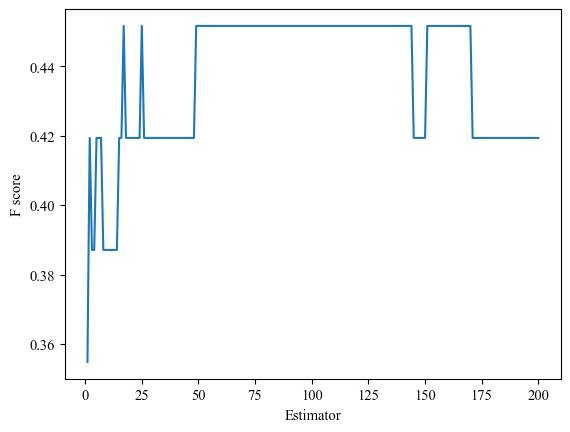

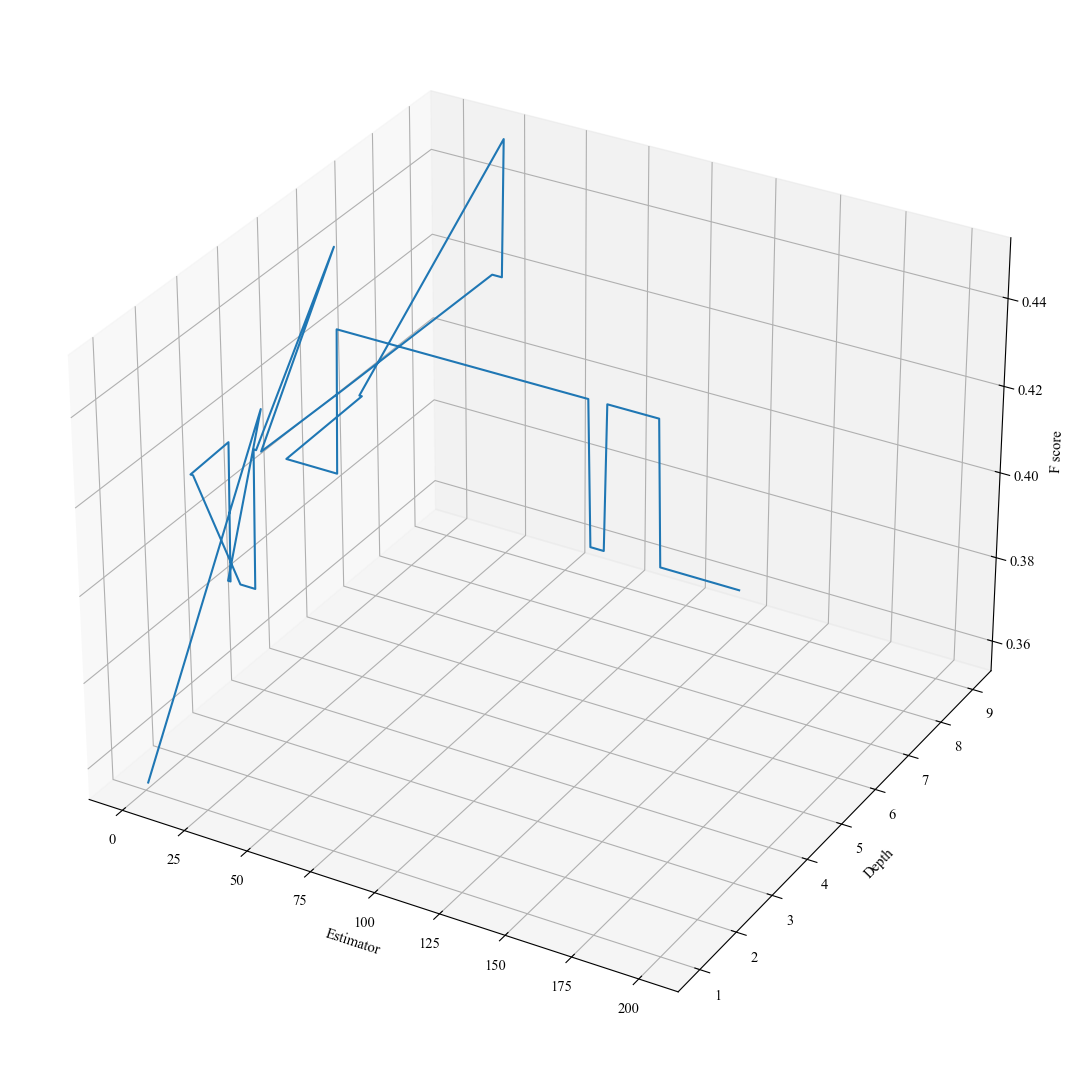

Best estimator: 17, Best depth: 5, Best test F score: 0.45161290322580644


In [83]:
# ランダムフォレストの各木の数・深さに対するF値を計算
n_estimators = range(1, 201)
best_depths = []
F_score = []
for n in n_estimators:
    clear_output(wait=True)
    print(f'Learning... [Estimator: {n}/{len(n_estimators)}]')
    F_score_test = []
    for depth in depths:
        model = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=1)
        model.fit(X_train, Y_train)
        Y_test_pred = model.predict(X_test)
        F_score_test.append(f1_score(Y_test, Y_test_pred, average="micro"))
    best_depths.append(depths[F_score_test.index(max(F_score_test))])
    F_score.append(max(F_score_test))
clear_output(wait=True)
print('>> Compreted ! <<')

# 結果をCSVに保存
results_df = pd.DataFrame({'Estimator': n_estimators, 'Depth': best_depths, 'F score': F_score})
results_df.to_csv('random_forest_F_score.csv', index=False)

# 木の数とF値の関係をグラフの描画
plt.figure()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10.5
plt.plot(n_estimators, F_score)
plt.xlabel('Estimator')
plt.ylabel('F score')
plt.show()

# 木の数に対する最適な深さとF値の関係を3次元グラフに描画
fig = plt.figure(figsize=(19.2, 10.8))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10.5
ax = fig.add_subplot(111, projection='3d')
ax.plot(n_estimators, best_depths, F_score)
ax.set_xlabel("Estimator")
ax.set_ylabel("Depth")
ax.set_zlabel("F score")
plt.tight_layout()
plt.show()

# 最終結果の出力
best_estimator = n_estimators[F_score.index(max(F_score))]
best_depth = best_depths[F_score.index(max(F_score))]
best_F_score = max(F_score)
print(f'Best estimator: {best_estimator}, Best depth: {best_depth}, Best test F score: {best_F_score}')

　グラフより，F値は 0.45161290322580644 が限界であることが分かる．最良モデルは，木の数が 17 のときは，深さが 5 の場合が最良となった．しかし，これは木の数が最小の場合を探索したもので，木の数が 49 以降で比較的安定し，その時の深さは 3 である．したがって，木の数と最適な深さの関係はトレードオフ（反比例？）といえる．  
$$E = \frac{k}{D},     (k = \text{const.})$$  
　木の数と精度（F値）の関係は，振動はあるものの，始め急増し，後に一定となることから，対数関数で記述可能であると考えられる．したがって，木の数を増やすことによって，F値を増加させるためには，木の数を指数関数的に増加させる必要があり，コンピュータの計算能力的に限界があることが分かる．あるいは，最適な木の深さは，負の精度（F値）に指数関数的に比例するが，深さの最小値は 1 であり，これ以上小さくできないことからも限界があることが分かる．  
$$F = a \log_b(E) + c ,    ({a, b, c} = \text{const.})$$  
$$\Rightarrow E = b ^ {\frac{F-c}{a}} \approx b ^ {F'}$$  
$$\Rightarrow D = kb^{-F'}$$  
　加えて，木の数が 1 のときは，最適な深さも 1 となっており，決定木のときに得られた結果と等しくなっていることが確認できる（F値も同値であった）．
#### (2) 最良ランダムフォレストモデルの説明変数の重要度（寄与度）と予測結果

Estimator:  17
Max depth= 5
F score: 0.45161290322580644


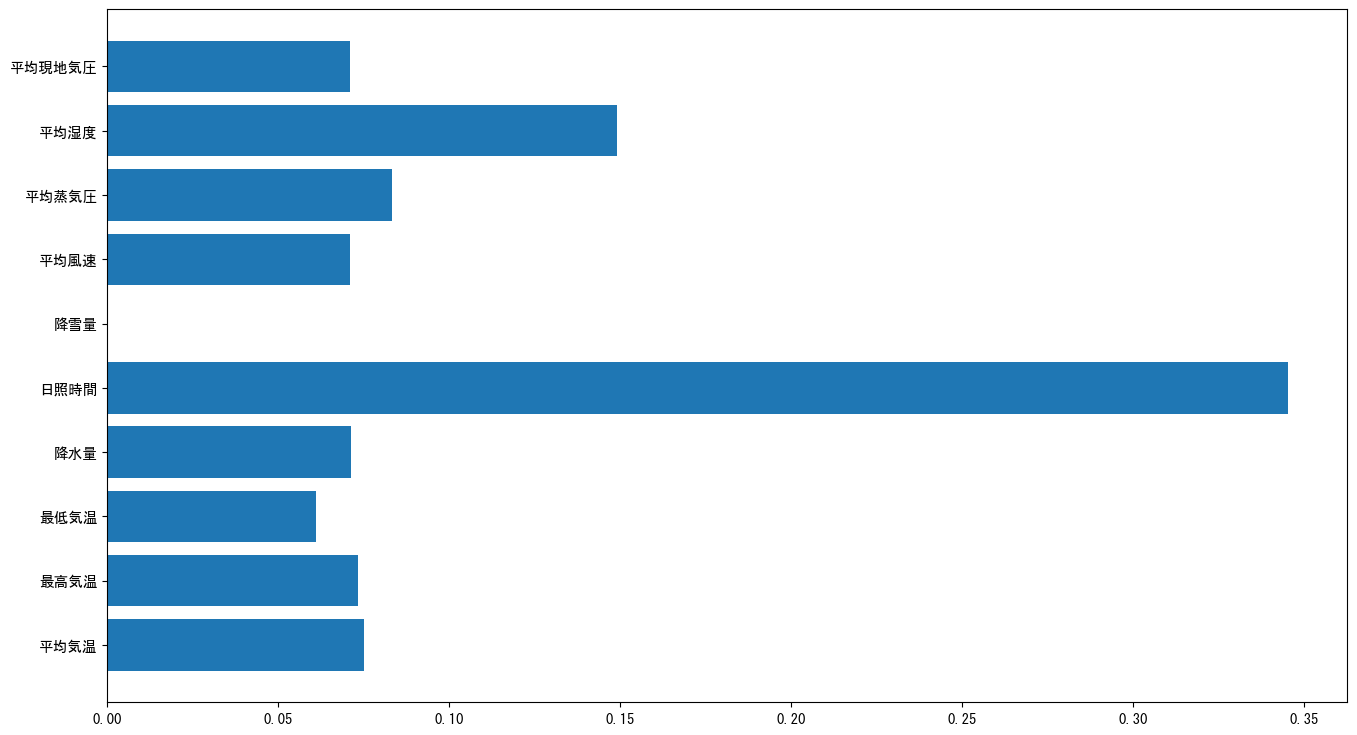

,Answer,Predict,True or False
0,晴,晴,True
1,晴,晴,True
2,晴,晴,True
3,晴,晴,True
4,晴,晴,True
5,晴後一時曇,晴,False
6,曇一時晴後雨,曇,False
7,雨後曇時々晴,曇時々晴後雨,False
8,晴,晴,True
9,晴後一時曇,晴時々曇,False


In [84]:
# 各説明変数の重要度（寄与率）を計算して描画
_n_estimator = best_estimator
_depth = best_depth
rf = RandomForestClassifier(n_estimators=_n_estimator, max_depth=_depth, random_state=1)
rf = rf.fit(X_train, Y_train)
print('Estimator: ', _n_estimator)
print('Max depth=', _depth)
print('F score:', f1_score(Y_test, rf.predict(X_test), average="micro"))
importances = rf.feature_importances_
plt.figure(figsize=(16, 9))
plt.rcParams['font.size'] = 10.5
plt.rcParams['font.family'] = 'MS Gothic'
plt.barh(range(len(X_name)), rf.feature_importances_)
plt.yticks(ticks=np.arange(len(X_name)), labels=X_name)
plt.show()

# 検証用データにおける正誤を表示しCSV形式で保存
TorF = (Y_test.to_numpy() == rf.predict(X_test))
results_df = pd.DataFrame({'Answer': Y_test, 'Predict': rf.predict(X_test), 'True or False': TorF})
display(results_df)
results_df.to_csv('best_model_corret.csv', index=False)

　こちらの結果でも，やはり，日照時間の値が天気を推定するために重要であることが確認できる．  
　決定木からの進歩としては，データに多く含まれる”晴”は正しく推定できていることに加え，”曇”や”曇時々晴”も推定できるようになり，F値が 0.5 付近（すなわち約 50 % の推定確率）まで上昇した．

### 感想  
　推定確率が 50 % 程度と聞くと，値としては物足りなさを感じるが，推定できていない場合の結果を確認すると，”晴後～”を”晴”や”晴時々～”などと予測したり，”～時々～”の順序が逆であったりする部分も多く，体感の精度はもう少し上昇するものと考えられる．  
　